# Dynamic decay and learning rate

This notebook demonstrates the affect of:
- ramping down the decay as learning progresses, and
- turning off the learning during the transient dynanmics.

That is, the decay rates for the value nodes and connection weights decay to zero as learning progresses.

Also, the learning is turned off at the beginning of each hold so that the connection weight matrix is not contaminated by the transients that the network goes through on its way to equilibrium. Instead, the weight updates are derived from the equilibrium states.

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## Dynamics for a 3-2 Predictive-Coding Network
The function below (`pc`) implements a 3-2 linear PC network. The numerical DE solvers call it to evaluates the right-hand side of the DEs.

To use it, the following must be defined in the workspace:
- `alpha`: clamp parameter for input layer
- `beta`: clamp parameter for output layer
- `lambda_x(t)`: decay rate for value nodes
- `lambda_M(t)`: decay rate for weights
- `Xinput(t)`: function that returns the inputs as a function of time
- `Yinput(t)`: function that returns the targets as a function of time
- `_LearningRate(t, d, hold)`: learning rate profile during a hold
- `learning_delay`: how long to wait during a hold before turning on learning

In [3]:
# 3-2 PC network
def pc(t, z):
    tau = 0.1
    gamma = 0.5
    
    if beta==0.:
        z[8:10] = Yinput(t)
    
    e0 = z[:3]
    x0 = z[3:6]
    e1 = z[6:8]
    x1 = z[8:10]
    M = np.reshape(z[10:16], (2,3))
    
    de0dt = ( x0 - Xinput(t) - e0 ) / tau
    dx0dt = ( M.T@e1 - alpha*e0 - lambda_x(t)*x0 ) / tau
    de1dt = ( x1 - M@x0 - e1 ) / tau
    dx1dt = ( -beta*e1 ) / tau
    
    if learning:
        dMdt = _LearningRate(t, learning_delay, hold)*( np.outer(e1, x0) - lambda_M(t)*M ) / gamma
    else:
        dMdt = np.zeros_like(M)
    
    dzdt = np.concatenate((de0dt, dx0dt, de1dt, dx1dt, dMdt.flatten()))
    return dzdt

In [4]:
def _Xinput(Xin, t, hold):
    n = len(Xin)
    tp = int( np.mod(t, n*hold) / hold )
    return Xin[tp]

In [5]:
def _Yinput(Yin, t, hold):
    n = len(Yin)
    tp = int( np.mod(t, n*hold) / hold )
    return Yin[tp]

In [6]:
def _LearningRate(t, d, hold):
    t_in_hold = t % hold
    return 1.-np.exp(-t_in_hold/d*4.)

In [7]:
# An abrupt, discontinuous version
# def _LearningRate(t, d, hold):
#     t_in_hold = t % hold
#     if t_in_hold>d:
#         return 1.
#     return 0.

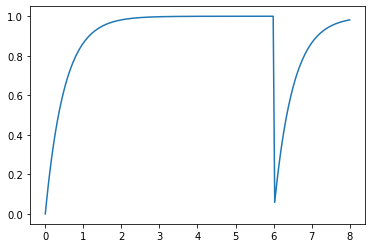

In [8]:
t = np.linspace(0, 8., 200)
learning_delay = 2.
plt.plot(t, [_LearningRate(tt, learning_delay, 6) for tt in t]);

### Dataset

In [9]:
# 3D - 2D
# Generate random inputs
np.random.seed(seed=313)
Xin = 2.*np.random.rand(2,3) - 1
Yin = np.array([[1., 0],
                 [0., 1]])
print(Xin)

[[-0.66892075  0.10020873  0.7217436 ]
 [ 0.23586745  0.89249277  0.12171594]]


## Training

In [10]:
# Hold each input for `hold` seconds
hold = 5.
Xinput = lambda t: _Xinput(Xin, t, hold)
Yinput = lambda t: _Yinput(Yin, t, hold)

# Define decay functions to decay exponentially over time
# so that the decay is insignificant by the end of the run.
lambda_x = lambda t: 0.05*np.exp(-t/10/hold)
lambda_M = lambda t: 0.05*np.exp(-t/10/hold)

alpha = 1. # 1=clamp bottom, 0=free bottom
beta = 0.  # 1=free top, 0=clamp top
learning_delay = 2.  # delay learning for about this long during each hold

M = np.random.normal(size=(2,3)) * 0.1  # random initial weights

learning = True   # turn learning on

# Parameters for numerical DE solver
tspan = [0, 50.*hold]
z0 = np.zeros(16)
z0[10:] = M.flatten()

# Call the numerical solver
sol = solve_ivp(pc, tspan, z0) # try adding max_step=1

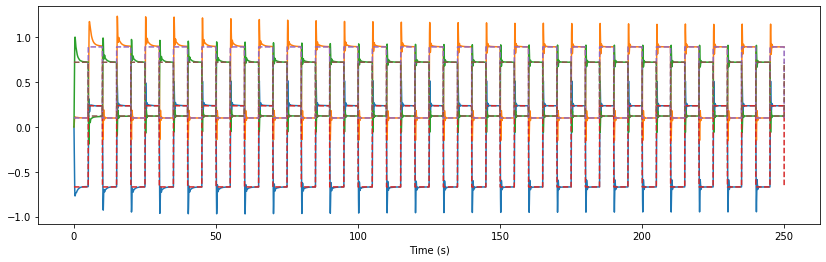

In [11]:
plt.figure(figsize=(14,4))
plt.plot(sol.t, sol.y[3:6].T);
Xi = np.array([Xinput(tt) for tt in sol.t])
plt.plot(sol.t, Xi, '--'); plt.xlabel('Time (s)');

In [12]:
Mnew = np.reshape(sol.y[10:16,-1], (2,3))
print(Mnew)

[[-0.67814723  0.0793497   0.73245842]
 [ 0.27593742  1.03008926  0.12250691]]


In [13]:
# Frobenius norm of connection weight matrix
print('Frobenius norm (squared) of optimal solution:')
np.sum(Mnew**2)

Frobenius norm (squared) of optimal solution:


2.1549086630660264

## Exact Solution

Solve $M X = Y$ for $M$. Or, equivalently, solve $X^\mathrm{T} M^\mathrm{T} = Y^\mathrm{T}$ for $M^\mathrm{T}$.

In [14]:
u, s, vt = np.linalg.svd(Xin, full_matrices=False)

In [15]:
Msvd = ( vt.T @ np.diag(1./s) @ u.T @ Yin.T ).T

In [16]:
print(Msvd)

[[-0.6894142   0.08193318  0.7352003 ]
 [ 0.28756404  1.02757     0.1238474 ]]


Check it!

In [17]:
print(Msvd@Xin.T)

[[1.00000000e+00 5.55111512e-17]
 [1.38777878e-16 1.00000000e+00]]


In [18]:
print('Frobenius norm (squared) of optimal solution:')
np.sum(Msvd**2)

Frobenius norm (squared) of optimal solution:


2.1764558302255885

## Discriminative Direction

In [19]:
M = Mnew
tspan = [0, 10.]
z0 = np.zeros(16)
z0[10:] = M.flatten()
alpha = 1. # clamp bottom layer
beta = 1.  # free top layer
learning = False  # turn learning off

In [20]:
# Run for class 0
Xinput = lambda t: Xin[0]
sol0 = solve_ivp(pc, tspan, z0) # try adding max_step=1

In [21]:
# Run for class 1
Xinput = lambda t: Xin[1]
sol1 = solve_ivp(pc, tspan, z0) # try adding max_step=1

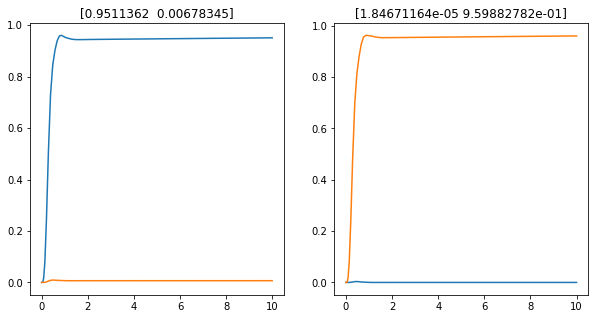

In [22]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1); plt.plot(sol0.t, sol0.y[8:10].T); plt.title(str(sol0.y[8:10,-1]));
plt.subplot(1,2,2); plt.plot(sol1.t, sol1.y[8:10].T); plt.title(str(sol1.y[8:10,-1]));

## Generative Direction

### First, with decay ON

In [23]:
M = Mnew
tspan = [0, 30.]
z0 = np.zeros(16)
z0 = np.random.normal(size=(16))  # Random initial state
z0[10:] = M.flatten() # Set connection weights
beta = 0.            # clamp top layer
alpha = 0.           # free bottom layer
learning = False     # turn learning off

In [24]:
lambda_x = lambda t: 0.02

In [25]:
# Set top layer input for class 0
Yinput = lambda t: Yin[0]
sol0 = solve_ivp(pc, tspan, z0)

In [26]:
# Set top layer input for class 0
Yinput = lambda t: Yin[1]
sol1 = solve_ivp(pc, tspan, z0)

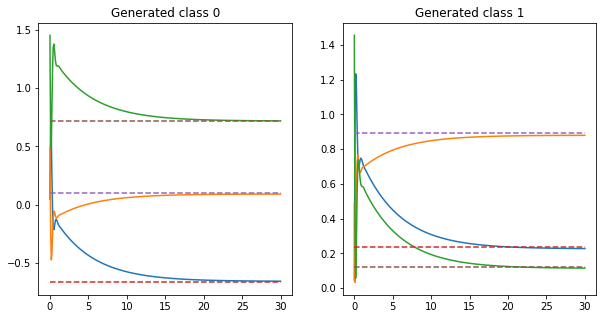

In [27]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1); plt.plot(sol0.t, sol0.y[3:6].T);
plt.plot(sol0.t[[0,-1]], np.vstack((Xin[0],Xin[0])),'--'); plt.title('Generated class 0');
plt.subplot(1,2,2); plt.plot(sol1.t, sol1.y[3:6].T);
plt.plot(sol1.t[[0,-1]], np.vstack((Xin[1],Xin[1])),'--'); plt.title('Generated class 1');

### Then, with decay OFF

In [28]:
# This sets the decay of the value nodes to zero.
lambda_x = lambda t: 0.0

In [29]:
# Set top layer input for class 0
# Use the same z0 as above
Yinput = lambda t: Yin[0]
sol0 = solve_ivp(pc, tspan, z0)

In [30]:
# Set top layer input for class 0
Yinput = lambda t: Yin[1]
sol1 = solve_ivp(pc, tspan, z0)

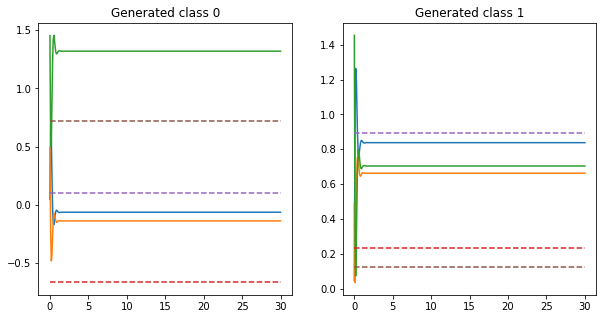

In [31]:
plt.figure(figsize=(10,5));
plt.subplot(1,2,1); plt.plot(sol0.t, sol0.y[3:6].T);
plt.plot(sol0.t[[0,-1]], np.vstack((Xin[0],Xin[0])),'--'); plt.title('Generated class 0');
plt.subplot(1,2,2); plt.plot(sol1.t, sol1.y[3:6].T);
plt.plot(sol1.t[[0,-1]], np.vstack((Xin[1],Xin[1])),'--'); plt.title('Generated class 1');

# PC Code

In [37]:
import NeuralNetwork
import Layer
import torch
dtype = torch.float
device = torch.device("cpu")
#device = torch.device("cuda:0") # Uncomment this to run on GPU

In [43]:
# Use A and B to make a dataset
def MakeDataset(A, B, n=300, noise=0.2):
    n_classes, top_dim = np.shape(A)
    bottom_dim = n_classes

    training_samples = n
    #noise = 0.2
    training_input = []
    training_output = []
    for n in range(training_samples):
        r = np.random.randint(n_classes)
        training_input.append(B[r])
        training_output.append(A[r]+noise*np.random.normal(size=np.shape(A[r])))

    training_input = torch.tensor(training_input).float().to(device)
    training_output = torch.tensor(training_output).float().to(device)
    train = [training_input, training_output]
    return train

def ClassPlot(x, labels=[], idx=(0,1)):
    # FeedForward
    #yc = Network.OneHot(y)
    if len(labels)>0:
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = np.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(x[:,idx[0]], x[:,idx[1]], color=colours, marker='.')
    else:
        plt.scatter(x[:,idx[0]], x[:,idx[1]], marker='.')
    plt.axis('equal');

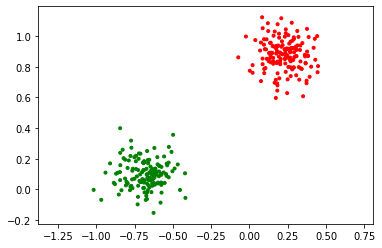

In [47]:
train = MakeDataset(Xin, Yin, noise=0.1)
ClassPlot(train[1], labels=train[1])

In [58]:
net0 = NeuralNetwork.NeuralNetwork()
net0.AddLayer( Layer.InputPELayer(n=len(train[0][0])) )
net0.AddLayer( Layer.TopPELayer(n=len(train[1][0])) )
net0.Connect(0, 1, act='identity', symmetric=True)
net0.SetTau(0.2)
net0.learning_tau = 0.08
net0.learn_bias = False

identity


In [59]:
net0.SetWeightDecay(0.05)
net0.SetvDecay(0.05)

In [60]:
net0.Learn(train[0], train[1], T=5., dt=0.001, epochs=4, batch_size=20, turn_down_lam=0.2, learning_delay=0.2)

FloatProgress(value=0.0, max=1200.0)

/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:981: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  c.lam = torch.tensor(w_decay).float().to(device)
/Users/jorchard/Dropbox/research/peBogacz/peBogacz/python/NeuralNetwork.py:977: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  l.v_decay = torch.tensor(v_decay).float().to(device)


turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2
turning down weight-decay and v-decay by a factor of 0.2


In [65]:
net0.SetvDecay(0.05)

In [66]:
mu0 = net0.Generate(5., train[1], dt=0.001)

In [52]:
mu0

tensor([[ 1.0330e-01,  8.4908e-01],
        [ 4.0685e-02,  9.1170e-01],
        [ 2.5108e-02,  9.2728e-01],
        [ 8.4278e-01,  1.0961e-01],
        [ 9.1174e-01,  4.0645e-02],
        [ 8.5022e-01,  1.0216e-01],
        [ 9.0506e-01,  4.7326e-02],
        [ 1.0818e+00, -1.2939e-01],
        [ 7.8495e-01,  1.6743e-01],
        [ 1.4974e-02,  9.3741e-01],
        [ 8.9080e-01,  6.1584e-02],
        [ 1.1864e-01,  8.3374e-01],
        [ 8.3176e-01,  1.2062e-01],
        [ 1.1751e-01,  8.3487e-01],
        [ 3.9145e-02,  9.1324e-01],
        [ 1.7635e-01,  7.7604e-01],
        [ 2.0896e-02,  9.3149e-01],
        [ 8.7715e-01,  7.5237e-02],
        [ 9.1103e-01,  4.1356e-02],
        [ 2.2300e-02,  9.3008e-01],
        [ 1.9140e-01,  7.6098e-01],
        [-5.0690e-02,  1.0031e+00],
        [ 9.2287e-01,  2.9514e-02],
        [-6.1804e-03,  9.5856e-01],
        [ 9.2269e-01,  2.9694e-02],
        [ 6.8400e-02,  8.8398e-01],
        [ 8.2026e-03,  9.4418e-01],
        [ 8.2439e-01,  1.279

In [57]:
mu0

tensor([[ 8.4801e-02,  8.6758e-01],
        [ 1.4740e-02,  9.3764e-01],
        [-1.7352e-03,  9.5412e-01],
        [ 8.3370e-01,  1.1868e-01],
        [ 9.0199e-01,  5.0396e-02],
        [ 8.3885e-01,  1.1353e-01],
        [ 8.9959e-01,  5.2793e-02],
        [ 1.0768e+00, -1.2438e-01],
        [ 7.7627e-01,  1.7612e-01],
        [-5.7405e-03,  9.5812e-01],
        [ 8.8431e-01,  6.8071e-02],
        [ 9.8264e-02,  8.5412e-01],
        [ 8.2307e-01,  1.2932e-01],
        [ 9.7498e-02,  8.5488e-01],
        [ 2.2310e-02,  9.3007e-01],
        [ 1.5686e-01,  7.9552e-01],
        [-2.3077e-03,  9.5469e-01],
        [ 8.6727e-01,  8.5115e-02],
        [ 8.9939e-01,  5.2996e-02],
        [-3.8913e-03,  9.5627e-01],
        [ 1.6913e-01,  7.8325e-01],
        [-7.9044e-02,  1.0314e+00],
        [ 9.1432e-01,  3.8067e-02],
        [-3.3119e-02,  9.8550e-01],
        [ 9.0687e-01,  4.5512e-02],
        [ 4.6053e-02,  9.0633e-01],
        [-1.4799e-02,  9.6718e-01],
        [ 8.0960e-01,  1.427

In [67]:
mu0

tensor([[ 8.3236e-02,  8.6914e-01],
        [ 6.7484e-03,  9.4563e-01],
        [-1.5094e-02,  9.6747e-01],
        [ 9.2882e-01,  2.3561e-02],
        [ 1.0181e+00, -6.5731e-02],
        [ 9.4610e-01,  6.2747e-03],
        [ 1.0095e+00, -5.7139e-02],
        [ 1.2054e+00, -2.5306e-01],
        [ 8.8446e-01,  6.7916e-02],
        [-2.3505e-02,  9.7588e-01],
        [ 9.9490e-01, -4.2522e-02],
        [ 1.1393e-01,  8.3845e-01],
        [ 9.2039e-01,  3.1989e-02],
        [ 1.0319e-01,  8.4919e-01],
        [ 1.8045e-02,  9.3433e-01],
        [ 1.7148e-01,  7.8090e-01],
        [-5.7347e-03,  9.5811e-01],
        [ 9.7752e-01, -2.5140e-02],
        [ 1.0056e+00, -5.3266e-02],
        [-9.3185e-03,  9.6170e-01],
        [ 1.7648e-01,  7.7590e-01],
        [-1.0335e-01,  1.0557e+00],
        [ 1.0174e+00, -6.5035e-02],
        [-5.3892e-02,  1.0063e+00],
        [ 1.0086e+00, -5.6226e-02],
        [ 3.6350e-02,  9.1603e-01],
        [-2.1735e-02,  9.7411e-01],
        [ 9.0036e-01,  5.202